# Flights Delay Exploratory Analysis
## by Abara Charles Ikenna

## Introduction
>The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights are recorded in the data. This report focuses on data from year 2004 to 2008. In this notebook, I will explore flight patterns and trends and also explore flight delays and the causes of flight delay.

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import os
from glob import glob

%matplotlib inline

Using 'os' and 'glob' libraries, a pandas DataFrame containging flights delay data from 2004-2008 will be created.

In [2]:
# load the flight delay data
files = os.path.join(os.getcwd(), '200*[45678].csv')
flights = pd.concat((pd.read_csv(data, low_memory=False) for data in glob(files)), ignore_index=True)

In [3]:
# load the plane data
aircrafts = pd.read_csv('plane-data.csv')

In [4]:
# overview of data shape and composition
print('Shape:{}'.format(flights.shape))
print()
print(flights.info())
print()
flights.head()

Shape:(31254220, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31254220 entries, 0 to 31254219
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2004,1,12,1,623.0,630,901.0,915,UA,462,...,7.0,11.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
1,2004,1,13,2,621.0,630,911.0,915,UA,462,...,16.0,16.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
2,2004,1,14,3,633.0,630,920.0,915,UA,462,...,4.0,15.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
3,2004,1,15,4,627.0,630,859.0,915,UA,462,...,4.0,10.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
4,2004,1,16,5,635.0,630,918.0,915,UA,462,...,3.0,13.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# check for null values
flights.isnull().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                608611
CRSDepTime                  0
ArrTime                675442
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                 42601
ActualElapsedTime      675442
CRSElapsedTime           1405
AirTime                675442
ArrDelay               675442
DepDelay               608611
Origin                      0
Dest                        0
Distance                    0
TaxiIn                  70096
TaxiOut                 64442
Cancelled                   0
CancellationCode     30645600
Diverted                    0
CarrierDelay          1804634
WeatherDelay          1804634
NASDelay              1804634
SecurityDelay         1804634
LateAircraftDelay     1804634
dtype: int64

I shall create a column called `DEPATURE_DATE` which contains the depature date of each flight. This column will be a datetime object generated from `Year`, `Month`, `DayOfMonth` columns.

In [6]:
# create DEPATURE_DATE column
flights['DEPATURE_DATE'] = pd.to_datetime(flights.Year*10000+flights.Month*100+flights.DayofMonth,format='%Y%m%d')

A flight is considered delayed when it arrived 15 or more minutes than the schedule . Delayed minutes are calculated for delayed flights only. When multiple causes are assigned to one delayed flight, each cause is prorated based on delayed minutes it is responsible for. The displayed numbers are rounded and may not add up to the total.

A new coloumn called `STATUS` will be created with dummy values 1-3. On time(0), delayed(1), diverted(2), cancelled(3)

In [7]:
for group in flights:
    flights.loc[flights['ArrDelay'] <= 15, 'STATUS'] = 0
    flights.loc[flights['ArrDelay'] >= 15, 'STATUS'] = 1
    flights.loc[flights['Diverted'] == 1, 'STATUS'] = 2
    flights.loc[flights['Cancelled'] == 1, 'STATUS'] = 3

In order to have a simplier analysis and work with a lighter dataset, I shall drop some unwanted features.

In [8]:
flights.drop(columns=[
    'DepTime', 'CRSDepTime','ArrTime', 'CRSArrTime', 'FlightNum',
    'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'TaxiIn', 'TaxiOut', 'DepDelay', 'Cancelled', 'Diverted',
    'Year', 'Month', 'DayofMonth', 'Distance', 'DayOfWeek'
], inplace=True)

In [9]:
# rename and refactor columns
flights.rename(columns={
    'UniqueCarrier': 'AIRLINE',
    'TailNum': 'TAIL_NUMBER',
    'ArrDelay': 'ARRIVAL_DELAY',
    'Origin': 'ORIGIN_AIRPORT',
    'Dest': 'DESTINATION_AIRPORT',
    'CancellationCode': 'CANCELLATION_CODE',
    'CarrierDelay': 'CARRIER_DELAY',
    'WeatherDelay': 'WEATHER_DELAY',
    'NASDelay': 'NAS_DELAY',
    'SecurityDelay': 'SECURITY_DELAY',
    'LateAircraftDelay': 'LATE_AIRCRAFT_DELAY',
    'DepDate': 'DEPATURE_DATE',
}, inplace=True)

flights = flights[['AIRLINE','TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPATURE_DATE',
                  'ARRIVAL_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
                  'LATE_AIRCRAFT_DELAY', 'CANCELLATION_CODE', 'STATUS']]

In [10]:
# drop null values from the aircrafts data
aircrafts.dropna(axis=0, inplace=True)

In [11]:
# Convert issue date to datatime object
aircrafts.issue_date = pd.to_datetime(aircrafts.issue_date, infer_datetime_format=True, errors='coerce')

Now the wrangled data set shall be reaccesed and saved to a csv file.

In [12]:
print('rows: {},  cols: {}'.format(flights.shape[0], flights.shape[1]))
print()
print(flights.columns)
print()
flights.tail()

rows: 31254220,  cols: 13

Index(['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DEPATURE_DATE', 'ARRIVAL_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'CANCELLATION_CODE', 'STATUS'],
      dtype='object')



,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPATURE_DATE,ARRIVAL_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CANCELLATION_CODE,STATUS
31254215,DL,N393DA,BOS,CVG,2008-04-17,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31254216,DL,N952DL,CVG,BOS,2008-04-17,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31254217,DL,N392DA,BOS,CVG,2008-04-17,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31254218,DL,N3756,CVG,BOS,2008-04-17,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31254219,DL,N951DL,BWI,CVG,2008-04-17,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [13]:
# save wrangled data to a data frame
#flights.to_csv('flights_delay.csv', index=False)
#aircrafts.to_csv('plane-data-wrangled.csv', index=False)

### What is the structure of your dataset?

> There are 31254220 entries in the dataset with 13 features:
* **DEPATURE_DATE** The depature date(datetime)
* **ARRIVAL_DELAY** arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
* **AIRLINE** unique carrier code
* **ORIGIN_AIRPORT** ORIGIN_AIRPORT IATA airport code
* **DESTINATION_AIRPORT** DESTINATION_AIRPORTination IATA airport code
* **CARRIER_DELAY** in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
* **WEATHER_DELAY** in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
* **NAS_DELAY** in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
* **SECURITY_DELAY** in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
* **LATE_AIRCRAFT_DELAY** in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
* **STATUS** on-time(0), delayed(1), diverted(2), cancelled(3)
* **CANCELLATION_CODE** reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

### What is/are the main feature(s) of interest in your dataset?

> My main interest is in the Arrival delay of flights. I want to investigate how many flights experience delays and what the causes of delays in flights are.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> The following features will help me investigate possible patterns and causes of flights delays: `ORIGIN_AIRPORT`, `DESTINATION_AIRPORTination`, `WEATHER_DELAY`, `NAS_DELAY`, `SECURITY_DELAY` and `LATE_AIRCRAFT_DELAY`. The `issue_date` in the planes data will help me investigate if older planes experience more delay than newer ones

## Univariate Exploration

I will start by defining several helper functions that will be used in my Exploratory analysis of the data.

In [14]:
# function to plot Histograms
def hist_plot(feature, *, bins, title="", xlabel="", ylabel=""):
    fig = plt.subplots(figsize=[6, 4])
    sns.histplot(feature, bins=bins)
    plt.title(title, fontsize=14, y=1.015)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# ------------------------
# function to plot barplot
def bar_plot(x, y, *, color=None, order=None, title="", labels=("", ""), rt=0):
    sns.barplot(x=x, y=y, color=color, order=order)
    plt.title(title, fontsize=14, y=1.015)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.xticks(rotation=rt)
    
# ------------------------
def get_pct(ax, feature):
    """
    fuction to add percentages to bars of barplots/countplots
    """
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12) 
    

I shall now begin exploring the nature of flight delays. I would like to know how long flight delays typicaly last and how many flights are delayed.

In [15]:
delayed_flights = flights[flights.STATUS == 1]

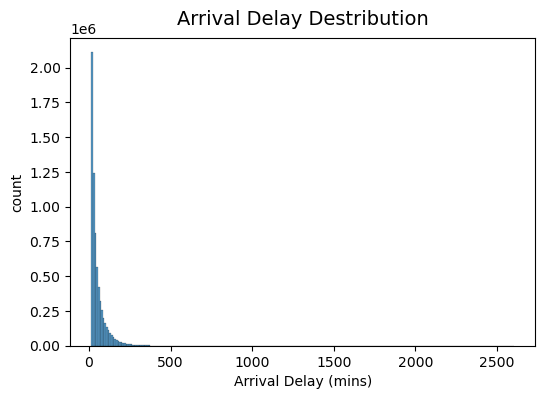

In [16]:
bins = np.arange(delayed_flights['ARRIVAL_DELAY'].min(), flights['ARRIVAL_DELAY'].max()+10, 10)
hist_plot(delayed_flights['ARRIVAL_DELAY'], bins=bins, title="Arrival Delay Destribution",
            xlabel="Arrival Delay (mins)", ylabel="count")

In [17]:
# Skewness
print("Skewness: {}".format(delayed_flights['ARRIVAL_DELAY'].skew()))

Skewness: 4.574074185804534


It can be seen from the histogram and the skewness that Arrival delays are mostly located on the left side of the graph and has a long tail to the left. This shows that most delays are short.

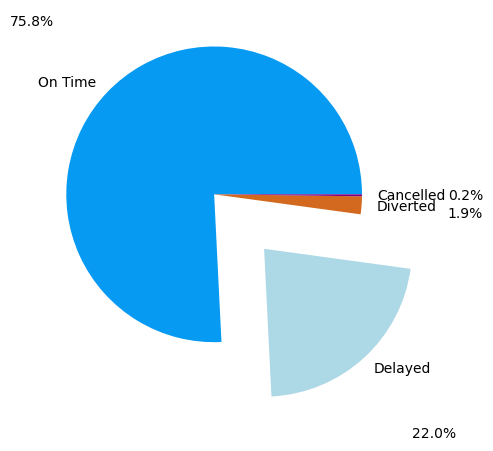

In [18]:
# plot a pie chart
labels = ["On Time", "Delayed", "Diverted", "Cancelled"]
sizes = flights['STATUS'].value_counts().to_list()
plt.pie(sizes, data=flights, labels=labels,  autopct='%1.1f%%', pctdistance=1.7, explode=(0.0, 0.5, 0, 0), normalize=True, 
       colors=['#069AF3', '#ADD8E6', '#D2691E', '#800080'])

plt.show()

75.8% Of all Flights from 2004 to 2008 Arrived on time while 22% were Delayed. During the same period, 1.9% of flights were diverted and 0.2% of flights were Cancelled. Further analysis could be carried out to gain more insight into flight delay,  cancellation and diverssion.

Some Airports have more flight activity than others, I would like to investigate if busier airports experience more delays. 

In [19]:
print('Number of Airports: {}'.format(flights.ORIGIN_AIRPORT.nunique()))

Number of Airports: 324


There are Over 300 Airports in this data set. I will limit my analysis to the top 30 busiest airports based on flights leaving the airports. The full names of the airports could be gotten from "airports.csv" dataset.

In [20]:
busiest_airports = flights.ORIGIN_AIRPORT.value_counts()[:30]

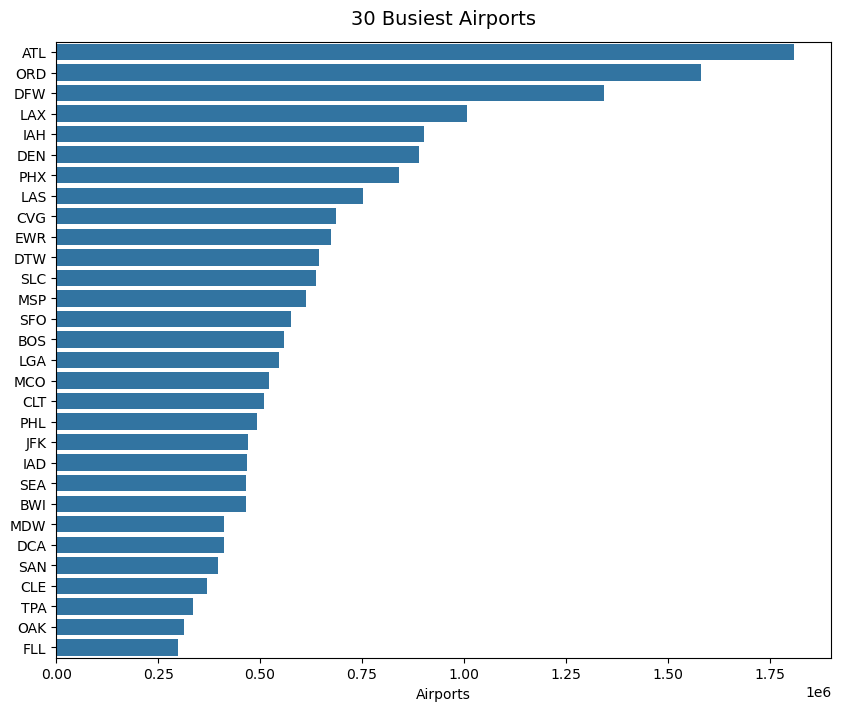

In [21]:
rcParams['figure.figsize'] = 10,8
title = "30 Busiest Airports"
bar_plot(busiest_airports, busiest_airports.index, color=sns.color_palette()[0], title=title, labels=("Airports", ""))

Next up, I will perform some exploratory analysis to determine flight activity for each day of the week, day of the month and month of the year

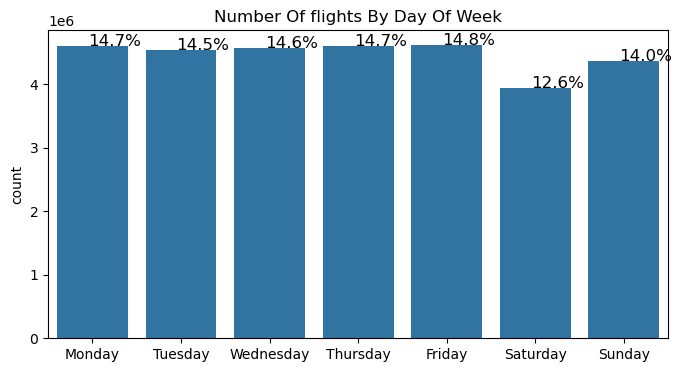

In [22]:
rcParams['figure.figsize'] = 8,4
day = flights['DEPATURE_DATE'].dt.day_name()
ax = sns.countplot(data=flights, x=day, color=sns.color_palette()[0], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number Of flights By Day Of Week')
plt.xlabel("")

get_pct(ax, day)

plt.show()

In [23]:
flights_per_month = flights.DEPATURE_DATE.dt.to_period('M').value_counts(sort=False)

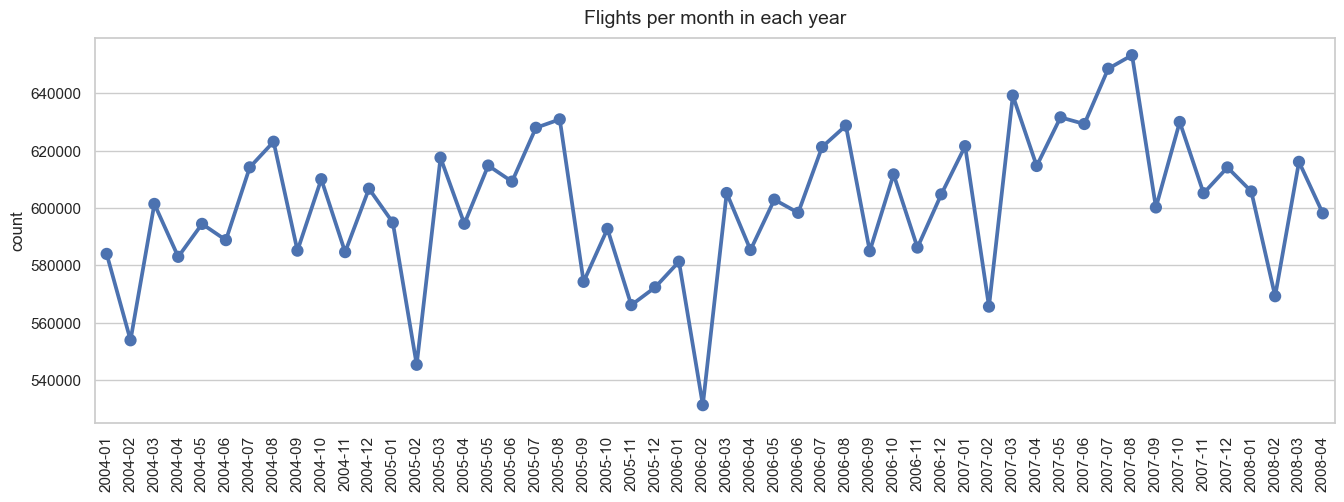

In [24]:
rcParams['figure.figsize'] = 16, 5
sns.set_theme(style="whitegrid")
sns.pointplot(y=flights_per_month, x=flights_per_month.index)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.title("Flights per month in each year", fontsize=14, y=1.015)

plt.show()

In [25]:
flights_per_dayofmonth = flights.DEPATURE_DATE.dt.day.value_counts(sort=False)

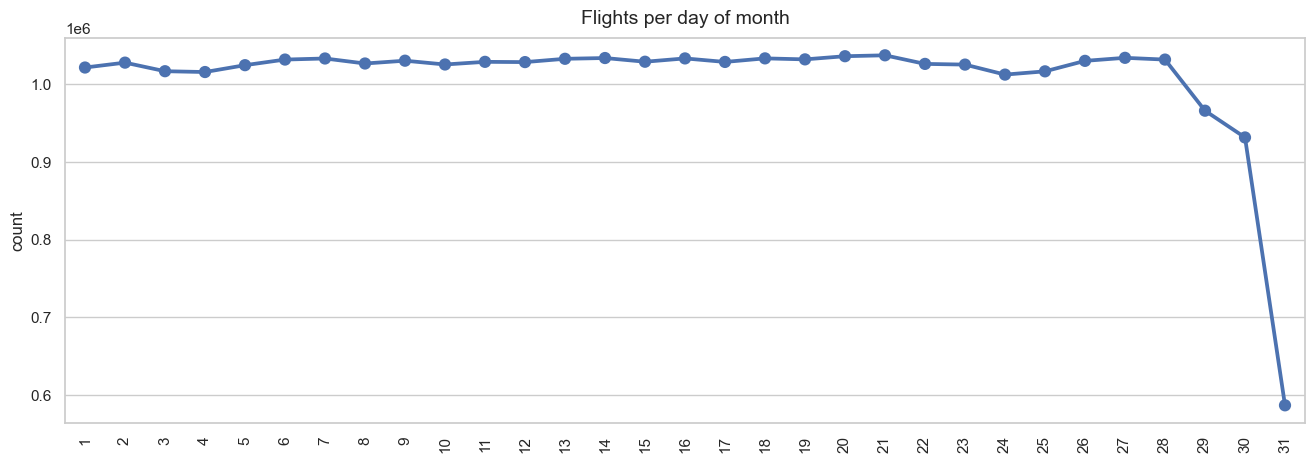

In [26]:
rcParams['figure.figsize'] = 16, 5
sns.set_theme(style='whitegrid')
sns.pointplot(y=flights_per_dayofmonth, x=flights_per_dayofmonth.index)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.title("Flights per day of month", fontsize=14, y=1.015)

plt.show()

From the above visualizations we It is observed that Saturdays and sundays have the least flight activities. For each year Febuary and August have the least and most flight activity respectivly compared to other months of the year. 2006-2 has the least flights overall and 2007-08 has the most flights overall

Now that we have an idea of nature and quantity of flight activies during each weekday, day of month and month. Could there be a relationship between flight activity and flight delay? Are busier days or month prone to more delays? We will attempt to answer these questions below. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The Destribution of `ARRIVAL_DELAY` was strongly right-skewed, this shows that most arrival delays and short. No further transformation was carried out.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Several operations were carried out in order to investigate flight activity. Pandas `to_period` fuction was used to group the Depature date into weekdays, day of months, months and years. This enabled me to determine which weekdays, day of month, month and year had the most flight activities. 

## Bivariate Exploration

In this section I shall exploere the relationship between several features and also carry out time trend analysis to determine the best day of the week/month to minimise delay. This will be done my comparing the average delay for each period.

In [27]:
# set base color to use for plots
base_color = sns.color_palette()[0]

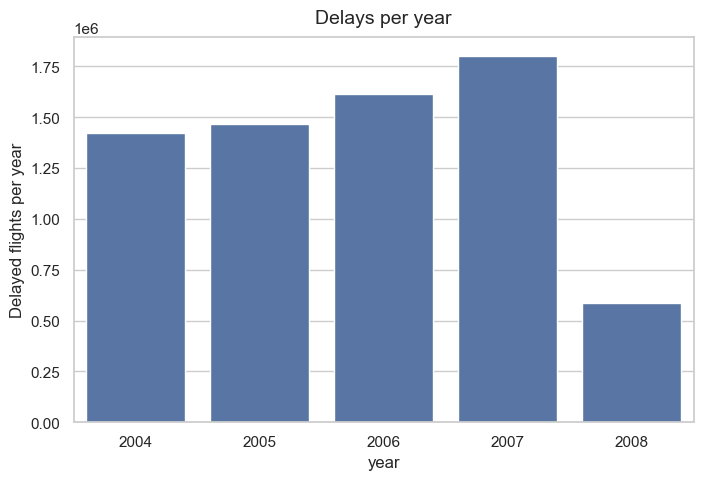

In [28]:
# Arrival delays per year
rcParams['figure.figsize'] = 8,5
sns.countplot(data=delayed_flights, x=delayed_flights['DEPATURE_DATE'].dt.to_period('Y'), color=base_color)

plt.title('Delays per year', fontsize=14, y=1.015)
plt.xlabel('year', fontsize=12)
plt.ylabel('Delayed flights per year', fontsize=12)

plt.show()

In [29]:
# Best time of the year to minimise delay 
avg_per_month = delayed_flights.groupby(flights.DEPATURE_DATE.dt.month_name()).mean()

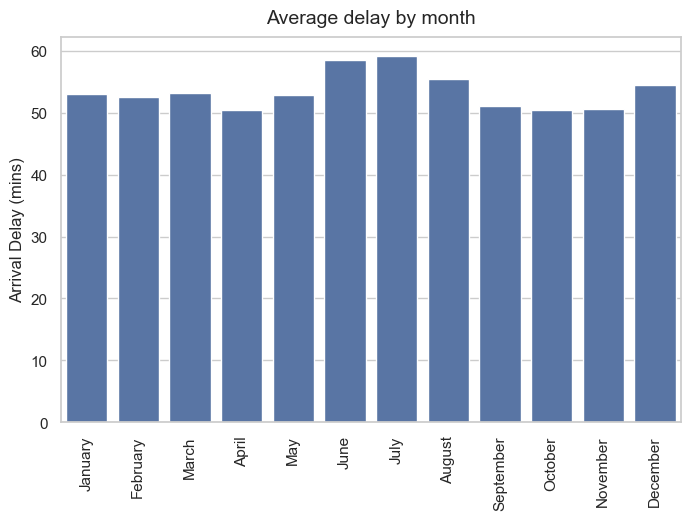

In [30]:
bar_plot(avg_per_month.index, avg_per_month.ARRIVAL_DELAY, color=base_color, rt=90,
        order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                'October', 'November', 'December'],
        title = 'Average delay by month',
        labels=("", "Arrival Delay (mins)"))

plt.show()

In [31]:
# Days of the week with the most/least delays
avg_per_week = delayed_flights.groupby(flights.DEPATURE_DATE.dt.day_name()).mean()

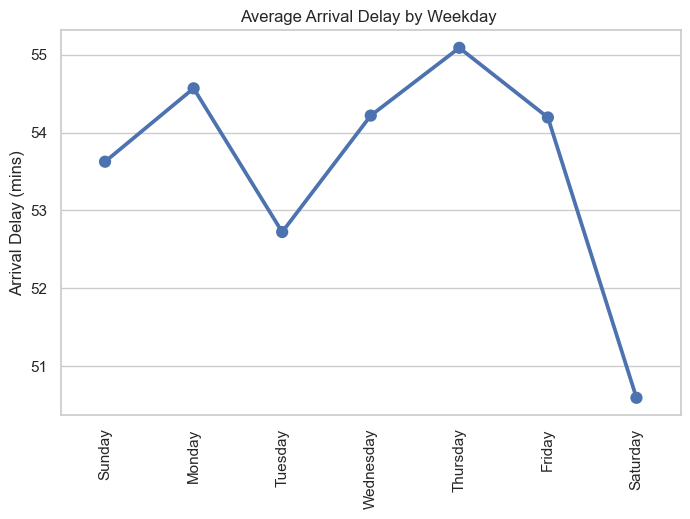

In [32]:
rcParams['figure.figsize'] = 8,5
sns.pointplot(data=avg_per_week, x=avg_per_week.index, y=avg_per_week.ARRIVAL_DELAY, color=base_color, 
          order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Average Arrival Delay by Weekday ')
plt.xlabel("")
plt.ylabel("Arrival Delay (mins)")
plt.xticks(rotation=90)

plt.show()

A correlation matrix of the dataset could be use to visualize the correlation between features. 

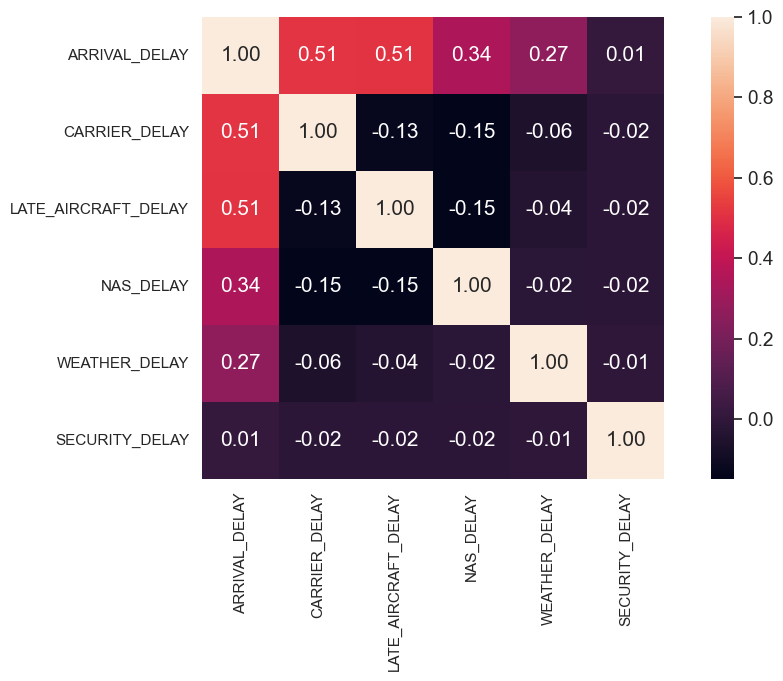

In [33]:
corrmat = delayed_flights.drop(columns=['STATUS']).corr()

k = 6 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 6))
cols = corrmat.nlargest(k, 'ARRIVAL_DELAY')['ARRIVAL_DELAY'].index
cm = np.corrcoef(delayed_flights[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the correlation matrix we can see that the main variable of interest has moderate positive correlation with WEATHER_DELAY, CARRIER_DELAY, NAS_DELAY and LATE_AIRCRAFT_DELAY. It has weak correlation with Security delay

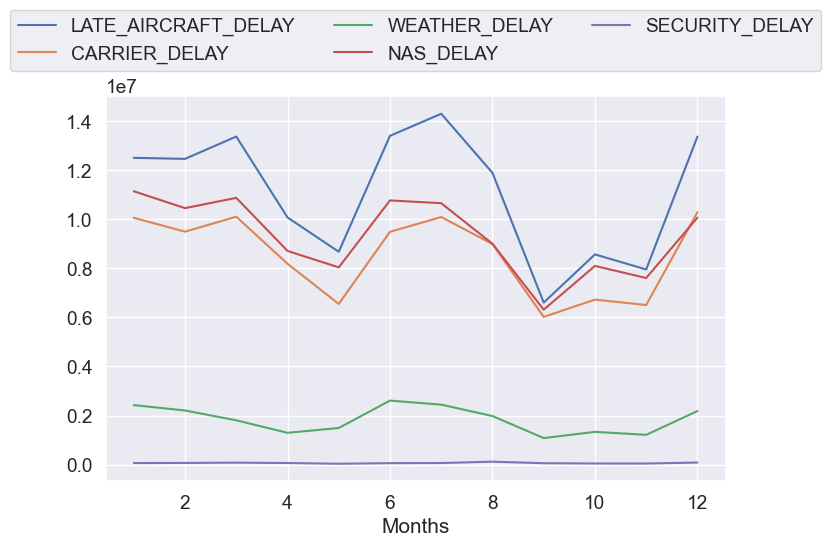

In [34]:
dlys = delayed_flights.filter(['DEPATURE_DATE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'], axis=1)
dlys = dlys.groupby(dlys.DEPATURE_DATE.dt.month)[['LATE_AIRCRAFT_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY']].sum().plot()
dlys.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=False)
plt.xlabel('Months')


plt.show()

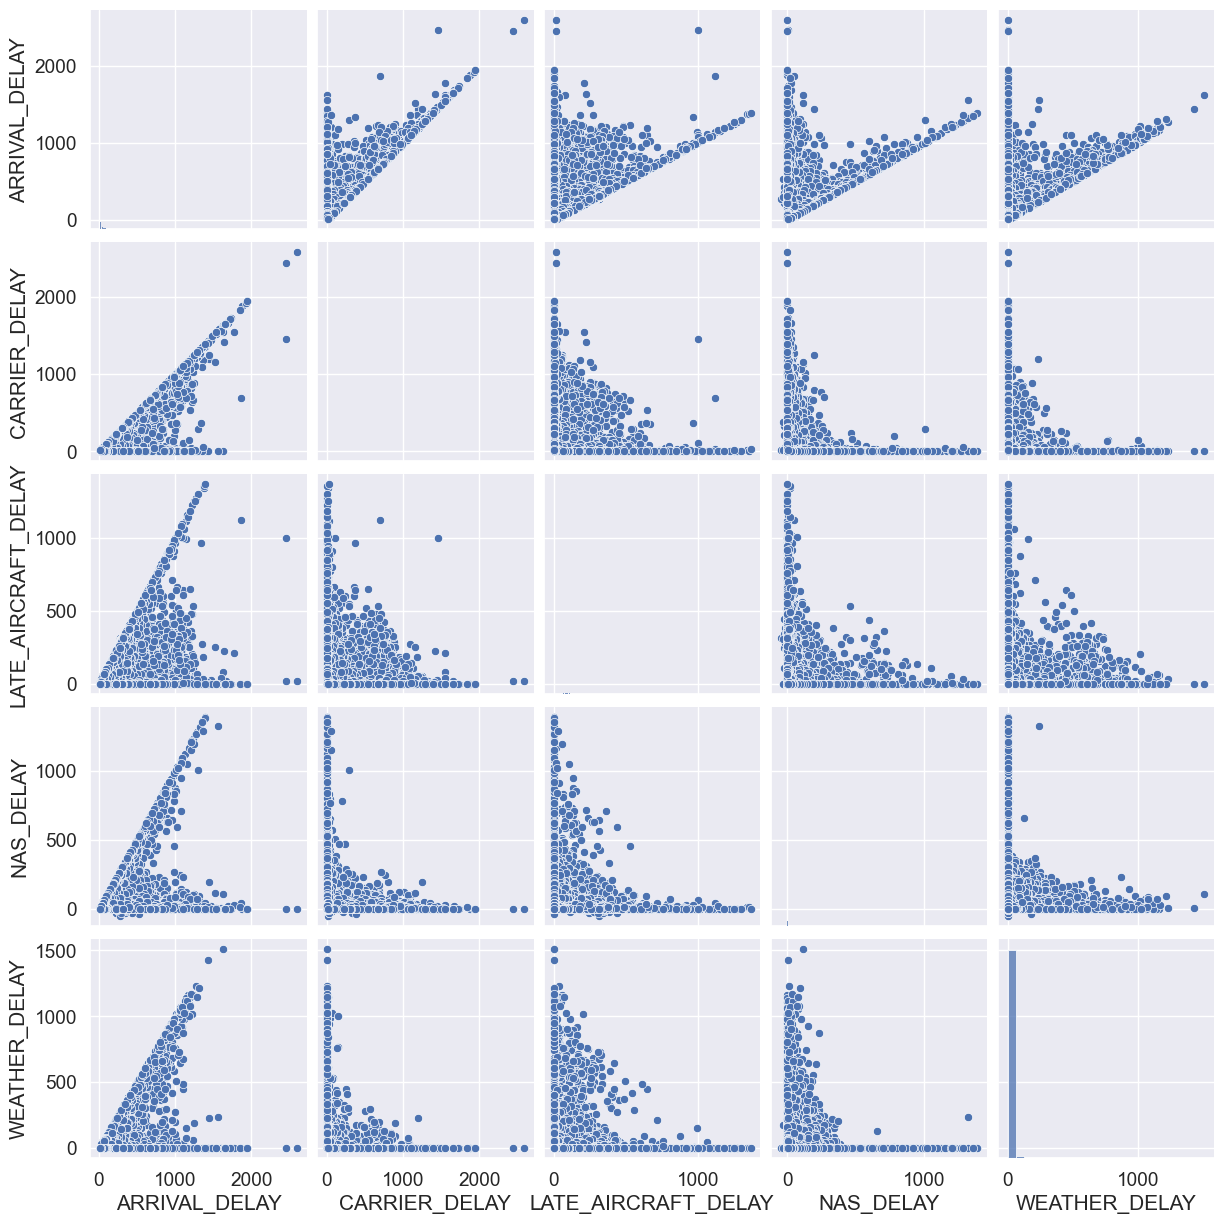

In [35]:
#scatterplot
cols = ['ARRIVAL_DELAY', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'NAS_DELAY', 'WEATHER_DELAY']
sns.pairplot(delayed_flights[cols], height = 2.5)
plt.show()

LATE_AIRCRAFT_DELAY seems to be the most influeintial delay cause. There doesn't seem to be any correlation between the different causes of delay.

#### What are the best and worst airports for flight delays?

In [36]:
top30 = busiest_airports.sort_values().index
top30_df = delayed_flights[delayed_flights.ORIGIN_AIRPORT.isin(top30)]

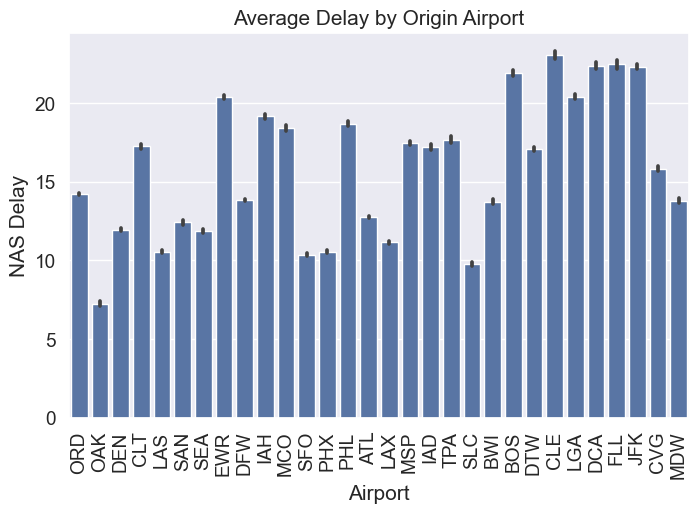

In [37]:
sns.barplot(x='ORIGIN_AIRPORT',y='NAS_DELAY', data=top30_df, color=base_color)
plt.title('Average Delay by Origin Airport')
plt.xticks(rotation=90)
plt.xlabel('Airport')
plt.ylabel('NAS Delay')

plt.show()

#### Average Delay by Carrier

The AIRLINE varialble contains the airline abreviations. The fullnames of the airlines can be obtained from the `carriers.csv` file

In [38]:
# load the carrier data
carriers = pd.read_csv('carriers.csv')

In [39]:
# function to replace very long description with shorter ones
def shorten(x):
    return x.split("(")[0]

# apply shorten function
carriers['Description'] = carriers['Description'].apply(shorten)

# create a dictionary with abreviation and description
airline_dict = carriers.set_index('Code')['Description'].to_dict()

In [40]:
# replace abbriviated airline name with full names
delayed_flights['AIRLINE'] = delayed_flights['AIRLINE'].replace(airline_dict)

C:\Users\HP\AppData\Local\Temp\ipykernel_7076\3111845928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_flights['AIRLINE'] = delayed_flights['AIRLINE'].replace(airline_dict)


C:\Users\HP\AppData\Local\Temp\ipykernel_7076\2627228644.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])


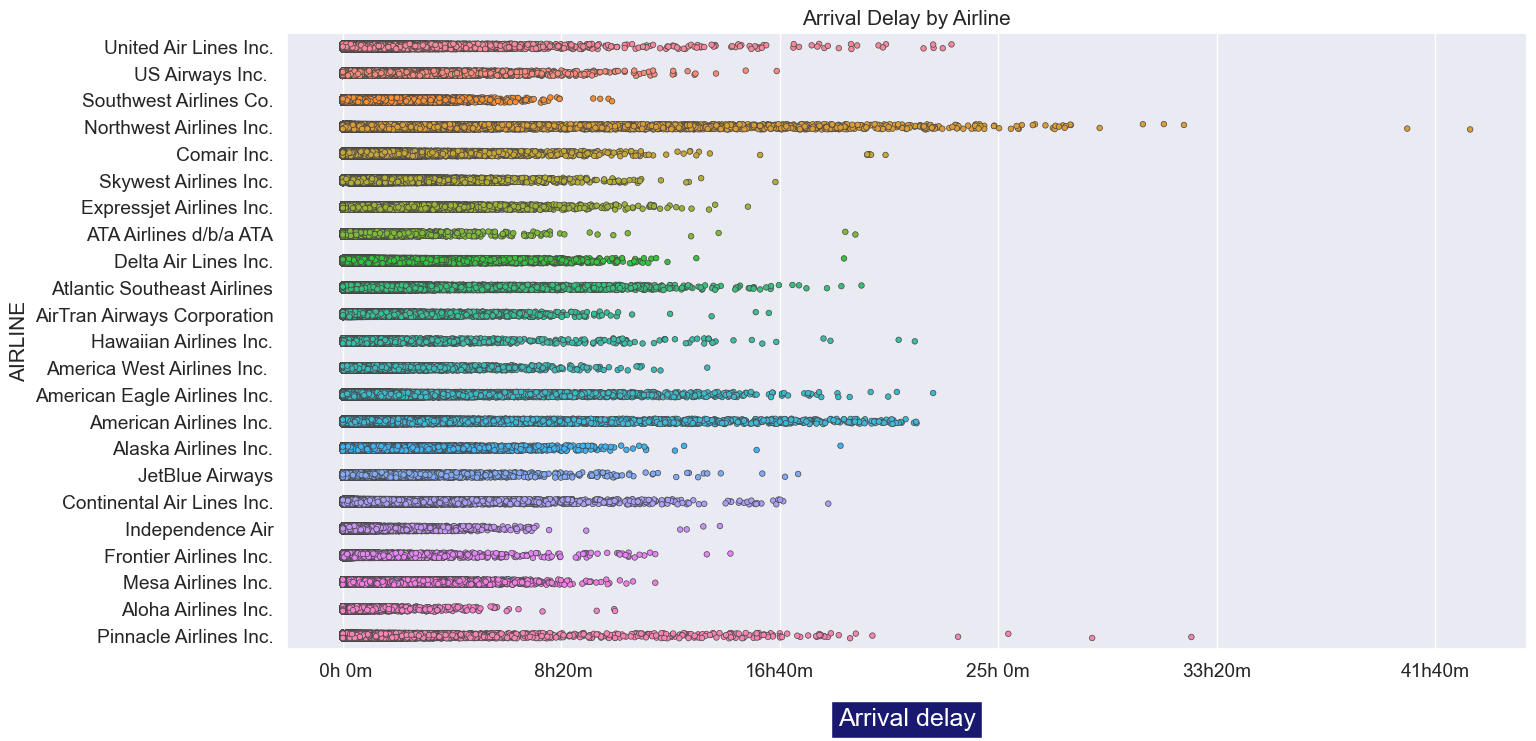

In [41]:
rcParams['figure.figsize'] = 16,8
ax = sns.stripplot(data=delayed_flights, y='AIRLINE', x='CARRIER_DELAY',
             size = 4, linewidth = 0.5,  jitter=True)


plt.xlabel('Arrival delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
#ax.set_xticks(ax.get_xticks().tolist())
ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax.get_xticks()])
ax.set_title("Arrival Delay by Airline")

plt.show()

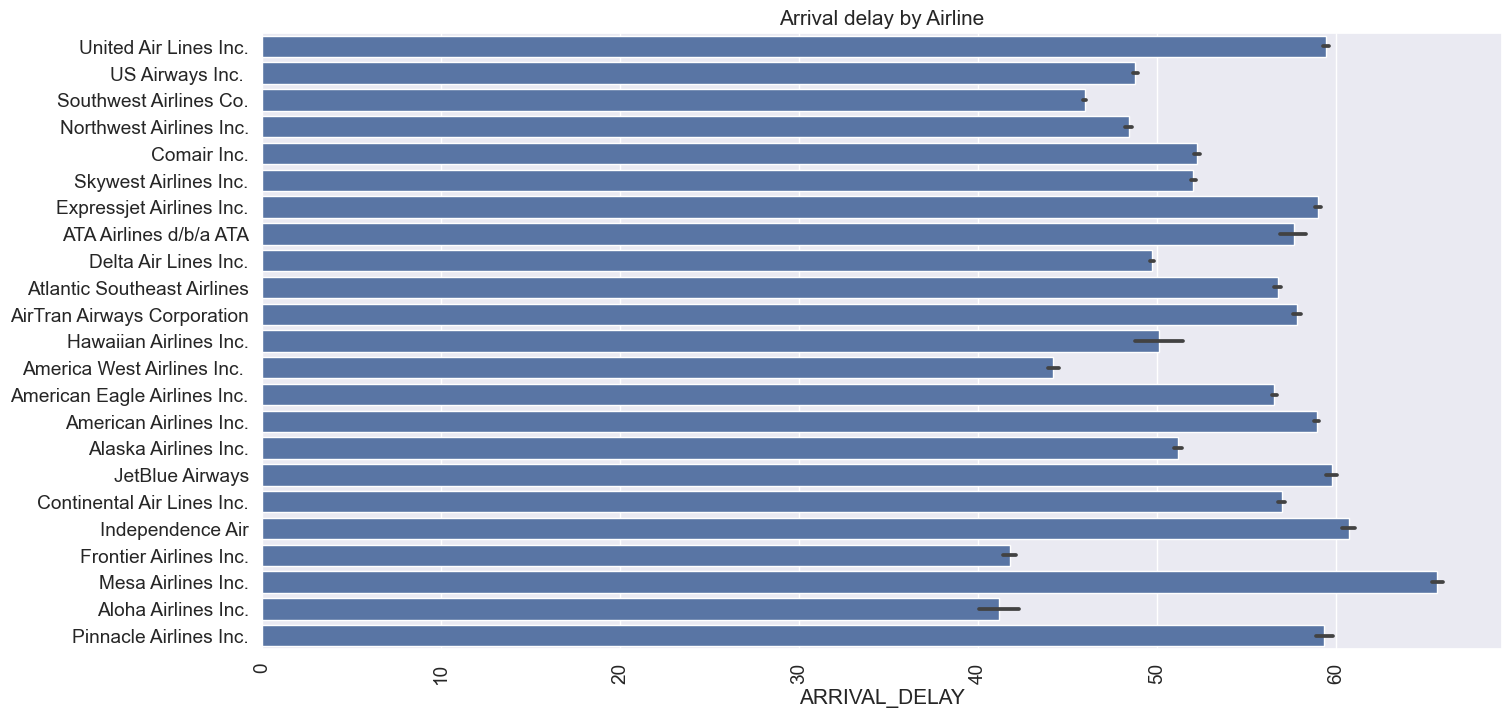

In [42]:
rcParams['figure.figsize'] = 16,8
ax = sns.barplot(data=delayed_flights, y='AIRLINE', x='ARRIVAL_DELAY', color=base_color)
ax.set_title('Average Delay by Carrier')
plt.xticks(rotation=90)
plt.ylabel("")
plt.title("Arrival delay by Airline")



plt.show()

Now let's take a look at cancelled flights. Only 0.2 percent of all scheduled flights were cancelled during this time frame, I would like to investigate the causes of flight cancellation.

In [43]:
cancelled_flights = flights[flights['STATUS'] == 3]

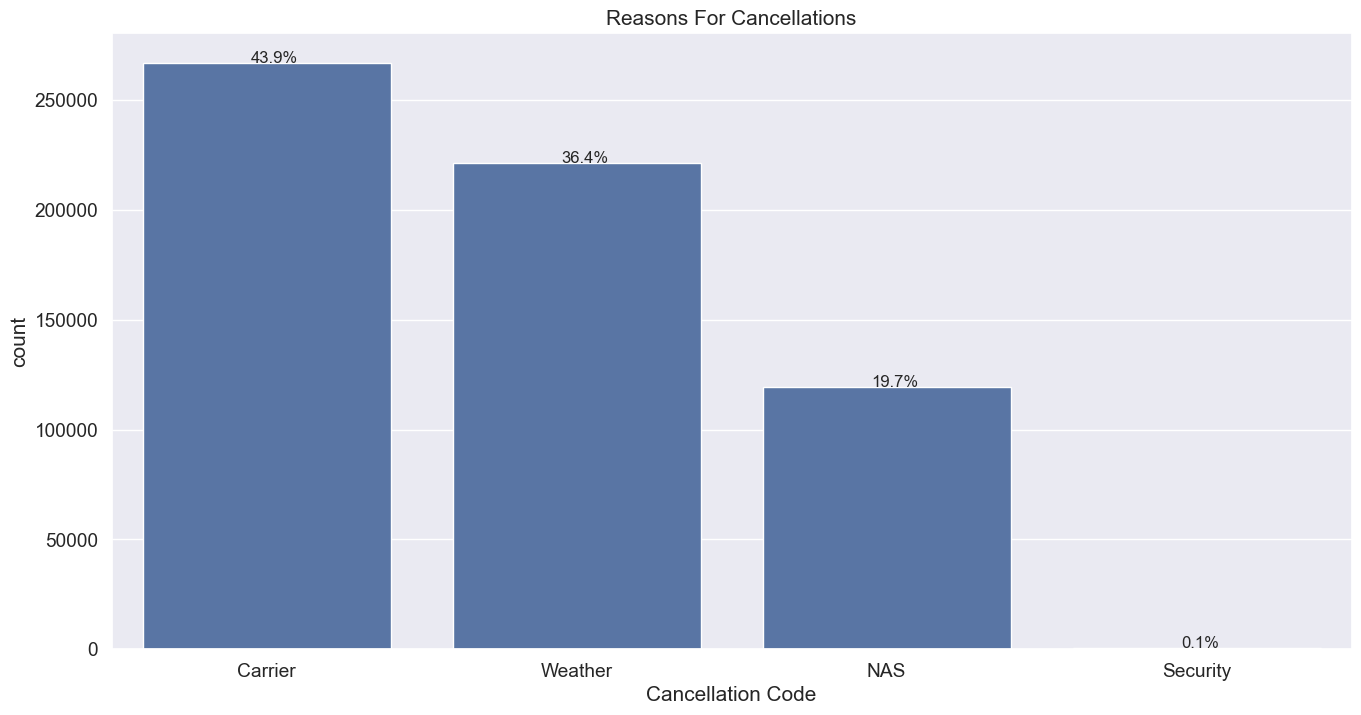

In [44]:
ax = sns.countplot(data=cancelled_flights, x='CANCELLATION_CODE', color=base_color, order=['A', 'B', 'C', 'D'])

labels = ['Carrier', 'Weather', 'NAS', 'Security']
plt.title('Reasons For Cancellations')
plt.xlabel('Cancellation Code')
ax.set_xticklabels(labels)

get_pct(ax, cancelled_flights.CANCELLATION_CODE)
plt.show()

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> My Bivariate Exploration started with a plot of total arrival delay against year, this plot showed that 2007 had the most delays in total. Taking a look at Average arrival delay, it was observed that some weekdays have higher average arrival delays than others with thursday having the highest and Saturday having the least. July has the highest arrival delay on average than other months. The correlation matrix and line plot shows that Late Aircraft is the most influencial cause of arrival delay.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

>  There were no noticable correlation between the various causes of delay. The analysis shows that the major cause of flight cancellation was due to Airline Carrier issues.

## Multivariate Exploration


I would like to study the contributions of each delay issue to the total arrival delay for each airline.

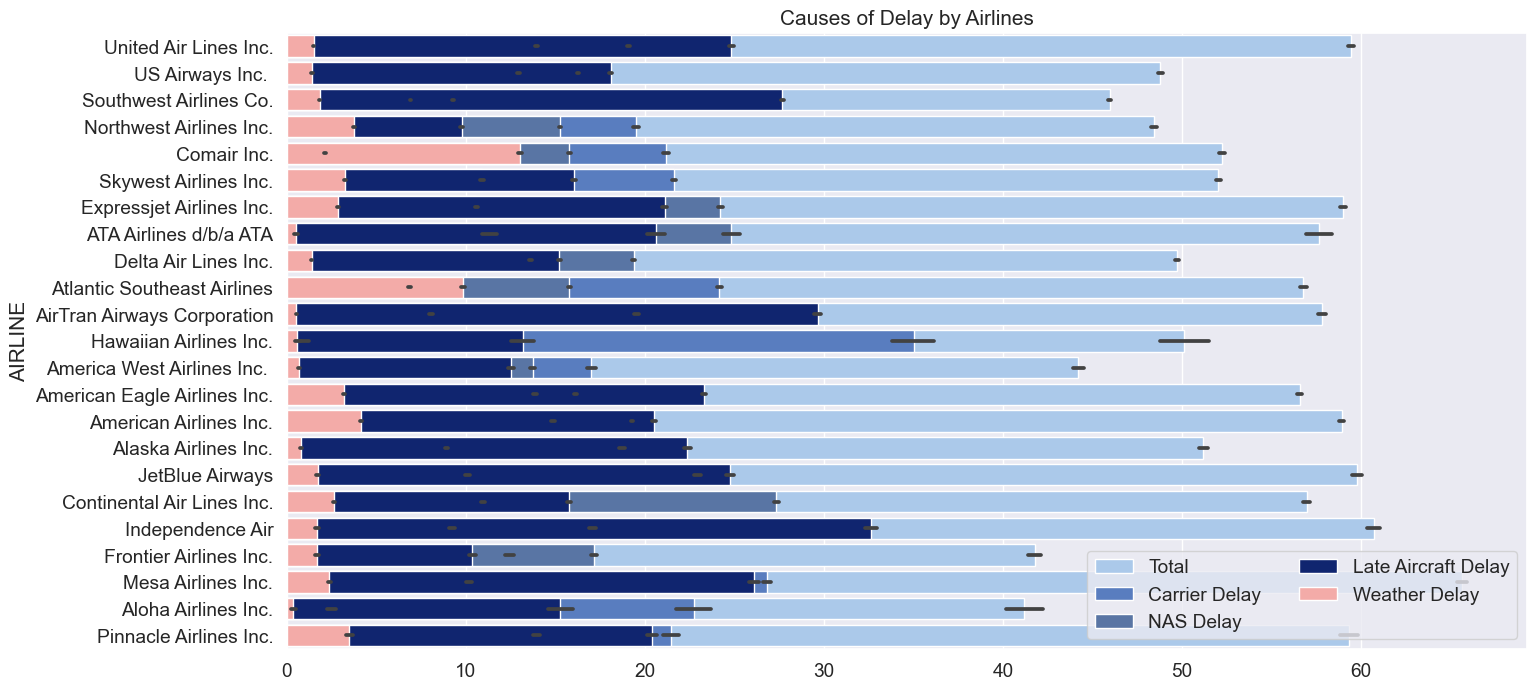

In [45]:
# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=delayed_flights,
            label="Total", color="b")

# plot carrier delays contribution
sns.set_color_codes("muted")
sns.barplot(x="CARRIER_DELAY", y="AIRLINE", data=delayed_flights,
            label="Carrier Delay", color="b")

# plot NAS delays contribution
sns.set_color_codes("deep")
sns.barplot(x="NAS_DELAY", y="AIRLINE", data=delayed_flights,
            label="NAS Delay", color="b")

# plot late_aircraft delays contribution
sns.set_color_codes("dark")
sns.barplot(x="LATE_AIRCRAFT_DELAY", y="AIRLINE", data=delayed_flights,
            label="Late Aircraft Delay", color="b")

# plot weather delays contribution
sns.set_color_codes("pastel")
sns.barplot(x="WEATHER_DELAY", y="AIRLINE", data=delayed_flights,
            label="Weather Delay", color="r")


plt.xlabel("")
plt.title("Causes of Delay by Airlines")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)


plt.show()

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> In this section, I used a stacked barplot to visualize the impact of the different causes of delay to the overall arrival delay for each Airline.

### Were there any interesting or surprising interactions between features?

> The results of my multivariate exploration of data is in line with what was found earlier. Late aircraft delay seems to be the most impactful countributor to arrival delay

## Conclusions
> After completing this exploratory data analysis we, have seen the general nature of flights delay and looked into the causes of flight delays using arrival delay as our reference. The insight gotten from exploring this dataset doesn't offer solutions to the delay issue, it's clear that delay reduction has many intertwined variables. This implies a solution applicable to one cause of delay would have compounding effects on other delay issues and delays in general
